# 📊 Descomposición de la Varianza (FEVD): ¿Quién manda en el modelo?

La Descomposición de la Varianza del Error de Pronóstico (FEVD) es una técnica que desglosa la variabilidad de cada variable en los aportes que hacen los "shocks" de las demás variables del sistema.

Si el Test de Granger nos decía si había relación, y la IRF nos decía cómo era esa relación, la VDC nos dice qué tan importante es esa relación en comparación con las demás.

## 1. 📝 El Concepto para Principiantes

Imagina que estás analizando el precio del **Pan**. El precio puede cambiar por dos razones:
1. Shocks internos (Sube el precio de la harina).
2. Shocks externos (Sube el precio del petróleo, lo que encarece el transporte).

La VDC nos dirá algo como: *"A 10 días plazo, el 70% de la variación del precio del pan se debe a sí mismo (harina), pero el 30% ya es explicado por el precio del petróleo"*.

### ¿Para qué sirve?
* **Cuantificar importancia:** Determinar cuál variable es la "líder" y cuál es la "seguidora".
* **Horizonte temporal:** Ver cómo la influencia de una variable crece o disminuye a medida que miramos más hacia el futuro.



---

## 2. 📊 Casos y sus Interpretaciones

La VDC siempre se expresa en **porcentajes (0% a 100%)**. Aquí te explico cómo leer los resultados:

| Escenario | Resultado Visual | Significado en Ciencia de Datos |
| :--- | :--- | :--- |
| **Variable Exógena (Independiente)** | Casi el 100% de su varianza se explica por sí misma en todos los pasos. | Esta variable es una "isla". Nada de lo que pase en las otras variables le afecta realmente. |
| **Variable Endógena (Dependiente)** | Al principio se explica por sí misma, pero con el tiempo otra variable toma un porcentaje alto (ej. 40%). | Esta variable es muy sensible. Es "esclava" de los movimientos de la otra variable. |
| **Interdependencia** | Ambas variables explican proporciones significativas de la otra (ej. 50/50). | Hay una retroalimentación fuerte. Ambas se afectan mutuamente de forma equilibrada. |

---

## 3. 🐍 Implementación y Visualización Profesional

Vamos a calcular la FEVD asegurándonos de que el código sea robusto ante diferentes versiones de la librería `statsmodels`.

c:\Users\delhy.py\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 📉 Análisis de la Varianza para la variable **Y**

Esta tabla muestra qué porcentaje de la incertidumbre de Y proviene de X a medida que pasa el tiempo.

,Explicado por Y (%),Explicado por X (%)
1,100.00%,0.00%
2,99.91%,0.09%
3,99.91%,0.09%
4,99.91%,0.09%
5,99.91%,0.09%
6,99.91%,0.09%
7,99.91%,0.09%
8,99.91%,0.09%
9,99.91%,0.09%
10,99.91%,0.09%


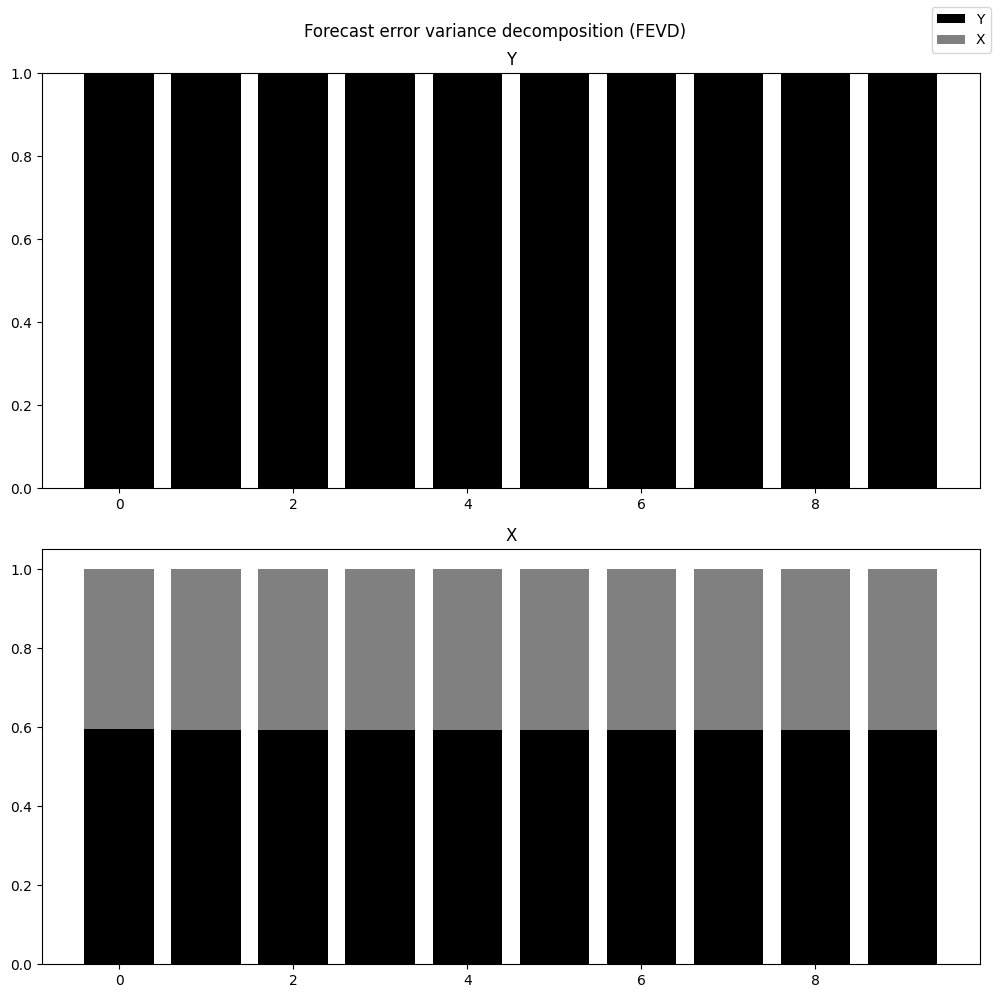

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from IPython.display import display, Markdown

# --- 1. Datos Sintéticos (X causa a Y) ---
np.random.seed(42)
N = 300
X = np.random.normal(0, 1, N).cumsum() # X es un camino aleatorio
Y = 0.6 * X + np.random.normal(0, 0.5, N).cumsum() # Y sigue a X

df = pd.DataFrame({'Y': Y, 'X': X}).diff().dropna()

# --- 2. Ajuste del Modelo ---
model = VAR(df)
results = model.fit(maxlags=5, ic='aic')

# --- 3. Cálculo de la FEVD ---
# Usamos un horizonte de 10 periodos
pasos = 10
# Nota: pasamos el número directamente para evitar errores de nombres de argumentos (steps/periods)
fevd = results.fevd(pasos)

# --- 4. Extracción de Datos para Y ---
# fevd.decomp[0] contiene la descomposición para la primera variable (Y)
vdc_y = pd.DataFrame(fevd.decomp[0] * 100, 
                     columns=['Explicado por Y (%)', 'Explicado por X (%)'],
                     index=range(1, pasos + 1))

display(Markdown(f"## 📉 Análisis de la Varianza para la variable **Y**"))
display(Markdown("Esta tabla muestra qué porcentaje de la incertidumbre de Y proviene de X a medida que pasa el tiempo."))

# Presentación con gradiente para ver el flujo de influencia
display(vdc_y.style.format("{:.2f}%").background_gradient(cmap='Wistia'))

# --- 5. Gráfico de Áreas Apiladas ---
# Esta es la forma estándar de ver la VDC
fig = fevd.plot()
plt.tight_layout()
plt.show()

## **4. 💡 3 Reglas de Oro para interpretar la VDC**

1. Suma siempre 100: En cada paso (fila), la suma de todas las contribuciones debe ser el 100%. Si X explica el 20%, el 80% restante debe ser explicado por Y o las demás variables.

2. El Paso 1 es engañoso: Normalmente, en el paso 1, cada variable se explica casi totalmente por sí misma. Lo interesante ocurre del paso 3 al 10, donde se ve si la influencia de la otra variable persiste o se desvanece.

3. Cuidado con el orden: Al igual que en la IRF, la VDC usa la "Ortogonalización de Cholesky". Si tus variables están muy correlacionadas, poner primero a X o primero a Y en el DataFrame puede cambiar ligeramente los porcentajes. Tip: Pon primero la variable que teóricamente creas que es la causa principal.